2024-09-26 19:59:42.175644: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 19:59:42.343413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 19:59:42.345578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 19:59:47.025367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Total samples in dataset: 1065
Total samples in training set: 852
Total samples in testing set: 213
Epoch 1/10


2024-09-26 20:00:37.702231: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-09-26 20:00:37.873769: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


 1/27 [>.............................] - ETA: 3:05 - loss: 7.5254 - accuracy: 0.5000

2024-09-26 20:00:42.646112: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-09-26 20:00:42.812097: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


 3/27 [==>...........................] - ETA: 1:30 - loss: 5.9799 - accuracy: 0.5595

2024-09-26 20:00:50.201679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


27/27 [==============================] - 171s 6s/step - loss: 2.4983 - accuracy: 0.7676 - val_loss: 0.2511 - val_accuracy: 0.9484
Epoch 2/10
27/27 [==============================] - 157s 6s/step - loss: 0.9029 - accuracy: 0.8826 - val_loss: 0.2110 - val_accuracy: 0.9718
Epoch 3/10
27/27 [==============================] - 172s 6s/step - loss: 0.5968 - accuracy: 0.9131 - val_loss: 0.2435 - val_accuracy: 0.9624
Epoch 4/10
27/27 [==============================] - 150s 6s/step - loss: 0.5329 - accuracy: 0.9272 - val_loss: 0.2189 - val_accuracy: 0.9812
Epoch 5/10
27/27 [==============================] - 138s 5s/step - loss: 0.2853 - accuracy: 0.9460 - val_loss: 0.1838 - val_accuracy: 0.9718
Epoch 6/10
27/27 [==============================] - 134s 5s/step - loss: 0.4009 - accuracy: 0.9343 - val_loss: 0.1704 - val_accuracy: 0.9765
Epoch 7/10
27/27 [==============================] - 131s 5s/step - loss: 0.2913 - accuracy: 0.9437 - val_loss: 0.1672 - val_accuracy: 0.9765
Epoch 8/10
27/27 [======

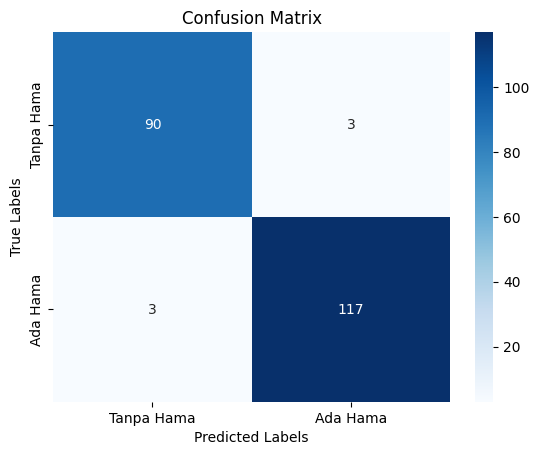

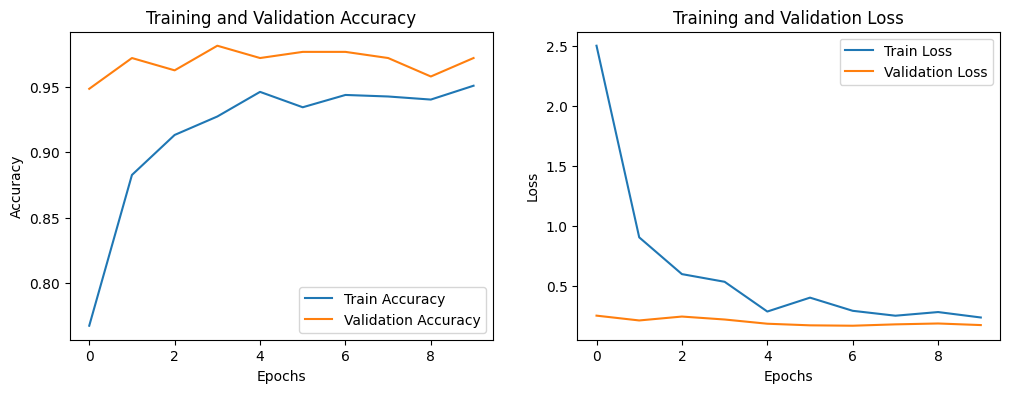

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from PIL import Image

path_ada_hama = 'Dataset/Data_Sawi_Ada_Hama'
path_tanpa_hama = 'Dataset/Data_Sawi_Tanpa_Hama'
input_image_folder = 'Input' 

image_size = (128, 128)
batch_size = 32
epochs = 10

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for root, _, files in os.walk(folder): 
        for filename in files:
            if filename.endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                img_path = os.path.join(root, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                img_array = preprocess_input(img_array)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

images_ada_hama, labels_ada_hama = load_images_from_folder(path_ada_hama, 1)
images_tanpa_hama, labels_tanpa_hama = load_images_from_folder(path_tanpa_hama, 0)

X = np.concatenate((images_ada_hama, images_tanpa_hama), axis=0)
y = np.concatenate((labels_ada_hama, labels_tanpa_hama), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

total_samples = X.shape[0]
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]

print(f'Total samples in dataset: {total_samples}')
print(f'Total samples in training set: {train_samples}')
print(f'Total samples in testing set: {test_samples}')

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False 

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test))

y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred, target_names=['Tanpa Hama', 'Ada Hama']))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Tanpa Hama', 'Ada Hama'], yticklabels=['Tanpa Hama', 'Ada Hama'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


1/1 [==============================] - 0s 203ms/step


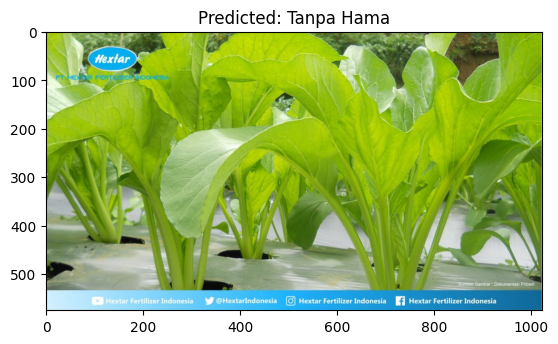

In [2]:
def predict_new_image(image_path):
    img = image.load_img(image_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = 'Ada Hama' if class_index == 1 else 'Tanpa Hama'
    
    plt.imshow(image.load_img(image_path))
    plt.title(f"Predicted: {class_label}")
    plt.show()

input_image_path = os.path.join(input_image_folder, os.listdir(input_image_folder)[0])
predict_new_image(input_image_path)